In [60]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load


In [61]:
vt_model = xgboost.XGBRegressor()
vt_model.load_model('../checkpoint/vt_xgboost_model.model')

In [62]:
full_df = pd.read_csv('../data_full/full_dataset.csv')
full_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,9.424700e-15,10,5,0
1,0.1,-19.8,9.424700e-15,10,5,0
2,0.1,-19.6,9.424700e-15,10,5,0
3,0.1,-19.4,9.424700e-15,10,5,0
4,0.1,-19.2,9.424700e-15,10,5,0


In [63]:
full_df['Vt'] = full_df.apply(lambda row : vt_model.predict([row[['W','L', 'T','Vds']].to_numpy()])[0], axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt
0,0.1,-20.0,9.424700e-15,10,5,0,0.999991
1,0.1,-19.8,9.424700e-15,10,5,0,0.999991
2,0.1,-19.6,9.424700e-15,10,5,0,0.999991
3,0.1,-19.4,9.424700e-15,10,5,0,0.999991
4,0.1,-19.2,9.424700e-15,10,5,0,0.999991


In [64]:
def calculate_drain_equation(width, length, vgs, vds, vt):
    right_term = (vgs-vt)*vds - 1/2*(vds**2)
    return (width/length)*right_term

In [87]:
full_df['Drain'] = full_df.apply(lambda row : calculate_drain_equation(row['W'], row['L'], row['Vgs'], row['Vds'], row['Vt']), axis=1)
print(full_df)

        Vds   Vgs           Ids     W   L   T        Vt         Drain
0       0.1 -20.0  9.424700e-15    10   5   0  0.999991     -4.209998
1       0.1 -19.8  9.424700e-15    10   5   0  0.999991     -4.169998
2       0.1 -19.6  9.424700e-15    10   5   0  0.999991     -4.129998
3       0.1 -19.4  9.424700e-15    10   5   0  0.999991     -4.089998
4       0.1 -19.2  9.424700e-15    10   5   0  0.999991     -4.049998
...     ...   ...           ...   ...  ..  ..       ...           ...
86827  30.0  19.2  1.238200e-02  1000  12  80  0.599660   9000.849754
86828  30.0  19.4  1.263100e-02  1000  12  80  0.599660   9500.849754
86829  30.0  19.6  1.288200e-02  1000  12  80  0.599660  10000.849754
86830  30.0  19.8  1.313300e-02  1000  12  80  0.599660  10500.849754
86831  30.0  20.0  1.338700e-02  1000  12  80  0.599660  11000.849754

[86832 rows x 8 columns]


In [117]:
class_0_df = full_df.query('Vgs<0')
class_1_df = full_df.query('Vgs>=0')

In [118]:
def custom_objective(y, y_hat, eps=1e-8):
    # grad = 2*np.log(abs(y_hat)/abs(y)-abs(y)+eps) + 2*((y_hat-y)/(y+eps))
    grad = 2*((y_hat-y)/(y+eps))
    hess = np.full(y_hat.shape, 2)
    # hess = np.full(y_hat.shape, 4)
    return grad, hess

In [119]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_0_y = class_0_df[['Ids']].to_numpy()
# scaler_0_y = StandardScaler().fit(class_0_y)
# class_0_y = scaler_0_y.transform(class_0_y)
class_0_y = np.log(class_0_y)
class_0_X = class_0_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_0_X = StandardScaler().fit(class_0_X)
class_0_X = scaler_0_X.transform(class_0_X)
dump(scaler_0_X, '../checkpoint/scaled_classified_vt_drain_xbgoost_class_0_std_scaler.bin', compress=True)
class_0_X_train, class_0_X_test, class_0_y_train, class_0_y_test = train_test_split(class_0_X, class_0_y, test_size=0.1)
class_0_xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:squarederror'],
                 'random_state':[2]}

class_0_xgb_grid = GridSearchCV(class_0_xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_0_X_train), len(class_0_X_test))
class_0_xgb_grid.fit(class_0_X_train,class_0_y_train)
print(class_0_xgb_grid.best_score_)
print(class_0_xgb_grid.best_params_)

39268 4364
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[18:32:08] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:32:08] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:32:08] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

In [120]:
# xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7, learning_rate=0.07, max_depth=5, min_child_weight=4, n_estimators=500, nthread=4, objective='reg:linear', silent=1, subsample=0.7)
# xgb_model = xgb_grid.best_estimator_
class_0_xgb_model.fit(class_0_X_train, class_0_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

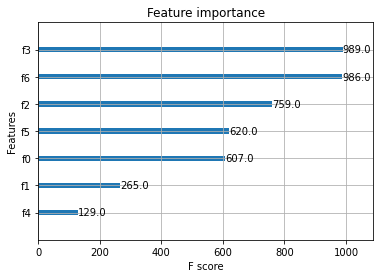

In [121]:
xgboost.plot_importance(class_0_xgb_model)

In [122]:
predictions = class_0_xgb_model.predict(class_0_X_test)
predictions

array([-30.687218, -30.199821, -28.588789, ..., -22.051758, -29.977255,
       -25.963905], dtype=float32)

In [123]:
class_0_y_test.flatten()

array([-30.68601519, -30.19920068, -28.58985407, ..., -22.05185749,
       -29.97825845, -25.96386161])

In [124]:
r_sq = class_0_xgb_model.score(class_0_X_train, class_0_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_0_y_test))

0.9999444337154018
0.9989846204399391


In [125]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = torch.log(torch.abs(y_hat)+eps)
    log_abs_y = torch.log(torch.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = y_hat.size(dim=0)
    return torch.sqrt((1/len_delta)*torch.sum((log_abs_delta/(log_abs_y+eps))**2)) + torch.sqrt((1/len_delta)*torch.sum((delta/(y+eps))**2))

In [126]:
predictions = class_0_xgb_model.predict(class_0_X_test)
# predictions = scaler_0_y.inverse_transform([predictions])
predictions = torch.tensor(np.exp(predictions))
print(predictions)
actuals = np.exp(class_0_y_test)
# actuals = scaler_0_y.inverse_transform(actuals)
actuals = torch.tensor(actuals.flatten())
print(actuals)
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)
    

tensor([4.7066e-14, 7.6627e-14, 3.8375e-13,  ..., 2.6488e-10, 9.5729e-14,
        5.2969e-12])
tensor([4.7123e-14, 7.6675e-14, 3.8334e-13,  ..., 2.6485e-10, 9.5633e-14,
        5.2971e-12], dtype=torch.float64)
tensor(0.0314, dtype=torch.float64)


In [127]:
class_0_xgb_model.save_model('../checkpoint/scaled_classified_vt_xgboost_class_0.model')

In [128]:
# full_df = pd.read_csv('../data_full/full_dataset.csv')
class_1_y = class_1_df[['Ids']].to_numpy()
class_1_y = np.log(class_1_y)
class_1_X = class_1_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_1_X = StandardScaler().fit(class_1_X)
class_1_X = scaler_1_X.transform(class_1_X)
dump(scaler_1_X, '../checkpoint/scaled_classified_vt_drain_xbgoost_class_1_std_scaler.bin', compress=True)
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(class_1_X, class_1_y, test_size=0.2)
class_1_xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
parameters = {'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['reg:squarederror'],
                 'random_state':[2]}

class_1_xgb_grid = GridSearchCV(class_1_xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

print(len(class_1_X_train), len(class_1_X_test))
class_1_xgb_grid.fit(class_1_X_train,class_1_y_train)
print(class_1_xgb_grid.best_score_)
print(class_1_xgb_grid.best_params_)

34560 8640
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[18:32:39] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:32:39] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:32:39] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

In [129]:
class_1_xgb_model.fit(class_1_X_train, class_1_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

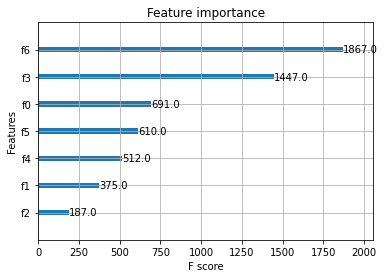

In [130]:
xgboost.plot_importance(class_1_xgb_model)

In [131]:
predictions = class_1_xgb_model.predict(class_1_X_test)
predictions

array([ -3.9252906, -11.592412 ,  -8.200001 , ...,  -7.803863 ,
       -15.343702 ,  -7.9979362], dtype=float32)

In [132]:
class_1_y_test.flatten()

array([ -4.0037546 , -11.5431682 ,  -8.27232729, ...,  -7.71687464,
       -15.3319136 ,  -8.04506682])

In [133]:
r_sq = class_1_xgb_model.score(class_1_X_train, class_1_y_train)
print(r_sq)
print(explained_variance_score(predictions,class_1_y_test))

0.9996537537158443
0.9994546445105212


tensor(0.0709, dtype=torch.float64)


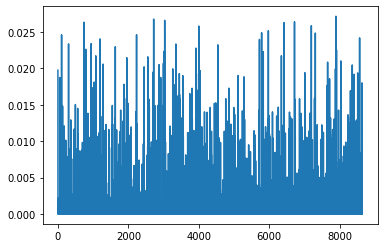

In [134]:
predictions = torch.tensor(np.exp(class_1_xgb_model.predict(class_1_X_test)))
actuals = torch.tensor(np.exp(class_1_y_test.flatten()))
nrmse = NRMSELoss(predictions, actuals)
print(nrmse)

plt.plot(predictions.numpy())

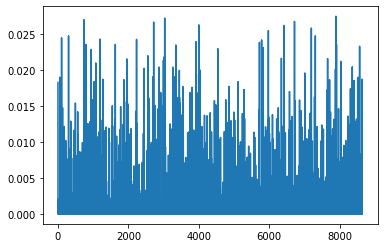

In [135]:
plt.plot(actuals.numpy())

In [136]:
class_1_xgb_model.save_model('../checkpoint/scaled_classified_vt_xgboost_class_1.model')